# Assignment 2

# Part 2: Classic recognition

Questions 2–7 are coding questions. You will implement different image representations and train linear classifiers with them. You will start with more flexible image representations and progressively move onto more rigid representations. Questions 8-10 are written questions to be answered in the PDF. You will report and reflect on the results, analyze the pros/cons of each representation and discuss possible improvements. 

In [1]:
import os, pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils import get_CIFAR10_data, train

## Setup

#### We provide you with a linear (softmax) classifier, as well as code to load the CIFAR-10 dataset.

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. See the dataset website for more details: https://www.cs.toronto.edu/~kriz/cifar.html.

**Do this:** Download the dataset from this link (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), place it where you want, and unzip it. Then try running the below code to see if you can load the dataset. Change `cifar10_dir` to your data path.

In [2]:
meta = pickle.load(open('/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py/batches.meta', 'rb'), encoding='bytes')
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


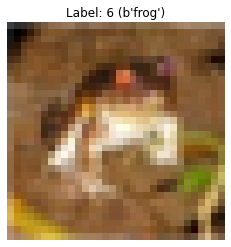

In [3]:
# Visualize a sample image
i = 0
label = y_train[i]
class_name = meta[b'label_names'][label]
plt.imshow(np.uint8(X_train[i])); plt.axis('off')
plt.title('Label: {} ({})'.format(label, class_name)); plt.show()

## Question 2. Color features (5 points)

First, we are going to explore using average color features to train a classifier. For each RGB color channel, average the pixel intensities. So a 32x32x3 image will be represented in a 1x3 vector.

**Do this:** Implement the average color feature. Then train a classifier. Tune the regularization strength to train a good classifier.

In [4]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# TODO: Compute average color features
X_train = np.mean(np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2], X_train.shape[3])), axis=1)
X_val = np.mean(np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2], X_val.shape[3])), axis=1)
X_test = np.mean(np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2], X_test.shape[3])), axis=1)

# TODO: Add bias dimension and transform into columns
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 4)
Train labels shape:  (4500,)
Validation data shape:  (500, 4)
Validation labels shape:  (500,)
Test data shape:  (1000, 4)
Test labels shape:  (1000,)


In [6]:
# TODO : Define regularization strengths
regularization_strengths = [10**i for i in range(-4, 5)]

# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)

reg 1.000000e-04 train accuracy: 0.141778 val accuracy: 0.152000
reg 1.000000e-03 train accuracy: 0.122000 val accuracy: 0.126000
reg 1.000000e-02 train accuracy: 0.127778 val accuracy: 0.140000
reg 1.000000e-01 train accuracy: 0.122889 val accuracy: 0.128000
reg 1.000000e+00 train accuracy: 0.126000 val accuracy: 0.138000
reg 1.000000e+01 train accuracy: 0.135111 val accuracy: 0.146000
reg 1.000000e+02 train accuracy: 0.133778 val accuracy: 0.150000
reg 1.000000e+03 train accuracy: 0.111778 val accuracy: 0.118000
reg 1.000000e+04 train accuracy: 0.099333 val accuracy: 0.116000

best validation accuracy achieved during training: 0.152000

final test set accuracy: 0.136000


## Question 3. Bag of SIFT features (15 points)

Bag of words models are a popular technique for image classification inspired by models used in natural language processing. The model ignores or downplays word arrangement (spatial information in the image) and classifies based on a histogram of the frequency of visual words. The visual word "vocabulary" is established by clustering a large corpus of local features. In this question, you will extract SIFT features from the training images. These result in a Nx128 dimensional matrix where N is the number of keypoints. After extracting SIFT features from all training images, we can use the K-means clustering algorithm to cluster these features into K clusters each represented by a 128-dimensional centroid. Now we have a bag of visual words (clusters) and can represent each image as a histogram of SIFT features assigned to these clusters. Specifically, each image will be represented as a K-dimensional histogram. Using these representations, you can train a classifier as before.

**Do this**: Extract SIFT features. Do K-means clustering of the training images' SIFT features. Construct a histogram representation of the images and train a classifier. Specifically, implement `extract_sift()` in `features.py`. 

#### Example for extracting SIFT features

Check out OpenCV's tutorial on extracting SIFT features: https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html.

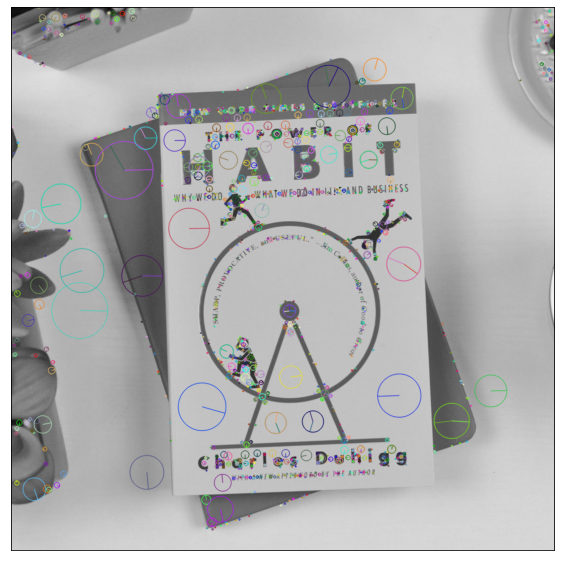

In [4]:
# Read in the image
img = cv2.imread('table.jpeg')

# Convert to greyscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Create a SIFT feature extractor
sift = cv2.xfeatures2d.SIFT_create()

# Detect features from the image
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Draw and visualize the detected keypoints on the image
sift_image = cv2.drawKeypoints(gray, keypoints, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10, 10))
plt.imshow(sift_image)
plt.xticks([]), plt.yticks([])
plt.show()

#### Your work starts here

In [5]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# TODO: Write a function to extract sift features
from features import extract_sift_for_dataset

In [7]:
# TODO: Define step_size (sampling density) for sampling keypoints in a grid.
step_size = 4

# TODO: Extract dense SIFT features
X_train_features = np.array(extract_sift_for_dataset(X_train, step_size=step_size))
dim = X_train_features.shape
X_train_features_flattened = np.reshape(X_train_features, (dim[0] * dim[1], dim[2]))

X_val_features = np.array(extract_sift_for_dataset(X_val, step_size=step_size))
dim = X_val_features.shape
X_val_features_flattened = np.reshape(X_val_features, (dim[0] * dim[1], dim[2]))

X_test_features = np.array(extract_sift_for_dataset(X_test, step_size=step_size))
dim = X_test_features.shape
X_test_features_flattened = np.reshape(X_test_features, (dim[0] * dim[1], dim[2]))

In [8]:
# TODO: Use your kmeans implementation from part 1 to cluster 
# the extracted SIFT features and build a visual vocabulary
# from kmeans import kmeans
from sklearn.cluster import KMeans

K = 30
niter = 300
# labels_train, centroids = kmeans(X_train_features_flattened, K, niter)
kmeans = KMeans(n_clusters=K, max_iter=niter).fit(X_train_features_flattened)

In [9]:
# TODO: Form histograms for images
# 1. Extract SIFT descriptors from an image
# 2. For each descriptor in the image, find the most similar centroid 
# 3. Increase the frequency of that centroid in the histogram for this image
# 4. Normalize the histogram for each image
# 5. Result: N by 7 Matrix where N is the number of images

def hist_creation(X, kmeans, num_of_images, num_of_descriptors, K):
    hist = np.zeros((num_of_images, K)) # number of images by K
    labels = kmeans.predict(X)
#     labels = labels.reshape(num_of_images, num_of_descriptors)
    # for each image, find its histogram of concepts
#     for row in range(labels.shape[0]):
#         for elem in labels[row]:
#             hist[row][elem] += 1
#         hist[row] = hist[row]/np.sum(hist[row])
        
        
    row = 0
    for i in range(len(labels)):
        if i != 0 and i % num_of_descriptors == 0:
#             hist[row] = hist[row]/np.sum(hist[row]) # normalize histogram
            row+=1

        hist[row][labels[i]] += 1
        
#     hist[row] = hist[row]/np.sum(hist[row]) # normalize final image's histrogram
    
    return hist

train_hist = hist_creation(X_train_features_flattened, kmeans, X_train_features.shape[0], X_train_features.shape[1], K)
val_hist = hist_creation(X_val_features_flattened, kmeans, X_val_features.shape[0], X_val_features.shape[1], K)
test_hist = hist_creation(X_test_features_flattened, kmeans, X_test_features.shape[0], X_test_features.shape[1], K)

# train_hist = np.zeros((X_train_features.shape[0], K)) # number of images by K
# dist = np.linalg.norm(centroids-X_train_features_flattened[:,np.newaxis], axis = 2)
# # assign each descriptor to the closest centroid based on this L2 norm value
# labels = np.argmin(dist, axis=1)
# labels = labels.reshape(X_train_features.shape[0], X_train_features.shape[1])
# # for each image, find its histogram of concepts
# for row in range(labels.shape[0]):
#     for elem in labels[row]:
#         train_hist[row][elem] += 1
#     train_hist[row] = train_hist[row]/np.sum(train_hist[row])

# val_hist = np.zeros((X_val_features.shape[0], K)) # number of images by K
# dist = np.linalg.norm(centroids-X_val_features_flattened[:,np.newaxis], axis = 2)
# # assign each descriptor to the closest centroid based on this L2 norm value
# labels = np.argmin(dist, axis=1)
# labels = labels.reshape(X_val_features.shape[0], X_val_features.shape[1])
# # for each image, find its histogram of concepts
# for row in range(labels.shape[0]):
#     for elem in labels[row]:
#         val_hist[row][elem] += 1
#     val_hist[row] = val_hist[row]/np.sum(val_hist[row])

# test_hist = np.zeros((X_test_features.shape[0], K)) # number of images by K
# dist = np.linalg.norm(centroids-X_test_features_flattened[:,np.newaxis], axis = 2)
# # assign each descriptor to the closest centroid based on this L2 norm value
# labels = np.argmin(dist, axis=1)
# labels = labels.reshape(X_test_features.shape[0], X_test_features.shape[1])
# # for each image, find its histogram of concepts
# for row in range(labels.shape[0]):
#     for elem in labels[row]:
#         test_hist[row][elem] += 1
#     test_hist[row] = test_hist[row]/np.sum(test_hist[row])

In [30]:
# TODO: Add bias dimension and transform into columns
X_train = np.hstack((train_hist, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((val_hist, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((test_hist, np.ones((X_test.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 31)
Train labels shape:  (4500,)
Validation data shape:  (500, 31)
Validation labels shape:  (500,)
Test data shape:  (1000, 31)
Test labels shape:  (1000,)


In [31]:
# TODO: Define regularization strengths
regularization_strengths = [10 ** i for i in range(-3, 4)]

# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)

reg 1.000000e-03 train accuracy: 0.138000 val accuracy: 0.158000
reg 1.000000e-02 train accuracy: 0.129556 val accuracy: 0.140000
reg 1.000000e-01 train accuracy: 0.167778 val accuracy: 0.174000
reg 1.000000e+00 train accuracy: 0.140000 val accuracy: 0.158000
reg 1.000000e+01 train accuracy: 0.165778 val accuracy: 0.172000
reg 1.000000e+02 train accuracy: 0.138889 val accuracy: 0.126000
reg 1.000000e+03 train accuracy: 0.256222 val accuracy: 0.290000

best validation accuracy achieved during training: 0.290000

final test set accuracy: 0.237000


## Question 4. SPM representation (15 points)

One drawback of the bag-of-words approach is that it discards spatial information. Hence, we will now try encoding spatial information using Spatial Pyramid Matching (SPM) proposed in Lazebnik et al. 2006. At a high level, SPM works by breaking up an image into different regions and computing the SIFT descriptor at each region, forming a histogram of visual words in each region, and then concatenatating them into a single 1D vector representation.

**Do this**: Construct a SPM representation of the images and train a classifier. Specifically, implement `spatial_pyramid_matching()` in `features.py`.

In [39]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [40]:
# TODO: Define parameters {L, K, niter}
L = 2 # Number of levels in SPM
K = 16
niter = 20
step_size = 1

# TODO: Extract SIFT features
X_train_features = np.array(extract_sift_for_dataset(X_train, step_size=step_size))
dim = X_train_features.shape
X_train_features_flattened = np.reshape(X_train_features, (dim[0] * dim[1], dim[2]))

X_val_features = np.array(extract_sift_for_dataset(X_val, step_size=step_size))
dim = X_val_features.shape
X_val_features_flattened = np.reshape(X_val_features, (dim[0] * dim[1], dim[2]))

X_test_features = np.array(extract_sift_for_dataset(X_test, step_size=step_size))
dim = X_test_features.shape
X_test_features_flattened = np.reshape(X_test_features, (dim[0] * dim[1], dim[2]))

# TODO: Use your kmeans implementation from part 1 
# to cluster the extracted SIFT features and build a visual vocabulary
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K, max_iter=niter).fit(X_train_features_flattened)

In [41]:
centroids = kmeans.cluster_centers_

In [50]:
# TODO: Write code to do SPM
from features import spatial_pyramid_matching

In [51]:
# TODO: Get a SPM representation of the extracted SIFT features
# Note: This may take some time to run
X_train_spm = [spatial_pyramid_matching(L, 
                                        X_train_features[i].reshape((32, 32, 128)), 
                                        centroids) 
               for i in range(len(X_train))]

X_val_spm = [spatial_pyramid_matching(L,
                                      X_val_features[i].reshape((32, 32, 128)), 
                                      centroids) 
             for i in range(len(X_val))]

X_test_spm = [spatial_pyramid_matching(L,
                                       X_test_features[i].reshape((32, 32, 128)),
                                       centroids)  
              for i in range(len(X_test))]

X_train_spm = np.array(X_train_spm)
X_val_spm = np.array(X_val_spm)
X_test_spm = np.array(X_test_spm)
print(X_train_spm.shape, X_val_spm.shape, X_test_spm.shape)

(4500, 80) (500, 80) (1000, 80)


In [52]:
# TODO: Add bias dimension and transform into columns
X_train = np.hstack((X_train_spm, np.ones((X_train_spm.shape[0], 1))))
X_val = np.hstack((X_val_spm, np.ones((X_val_spm.shape[0], 1))))
X_test = np.hstack((X_test_spm, np.ones((X_test_spm.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 81)
Train labels shape:  (4500,)
Validation data shape:  (500, 81)
Validation labels shape:  (500,)
Test data shape:  (1000, 81)
Test labels shape:  (1000,)


In [53]:
# TODO: Define regularization strengths
# regularization_strengths = [10 ** i for i in range(-3, 4)]
regularization_strengths = np.linspace(0, 10000, 100)

# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)

reg 0.000000e+00 train accuracy: 0.140222 val accuracy: 0.166000
reg 1.010101e+02 train accuracy: 0.102000 val accuracy: 0.102000
reg 2.020202e+02 train accuracy: 0.134667 val accuracy: 0.120000
reg 3.030303e+02 train accuracy: 0.148000 val accuracy: 0.128000
reg 4.040404e+02 train accuracy: 0.138000 val accuracy: 0.172000
reg 5.050505e+02 train accuracy: 0.149333 val accuracy: 0.124000
reg 6.060606e+02 train accuracy: 0.153556 val accuracy: 0.148000
reg 7.070707e+02 train accuracy: 0.167333 val accuracy: 0.162000
reg 8.080808e+02 train accuracy: 0.187111 val accuracy: 0.204000
reg 9.090909e+02 train accuracy: 0.216222 val accuracy: 0.272000
reg 1.010101e+03 train accuracy: 0.223333 val accuracy: 0.222000
reg 1.111111e+03 train accuracy: 0.247111 val accuracy: 0.234000
reg 1.212121e+03 train accuracy: 0.253778 val accuracy: 0.244000
reg 1.313131e+03 train accuracy: 0.253333 val accuracy: 0.262000
reg 1.414141e+03 train accuracy: 0.256667 val accuracy: 0.286000
reg 1.515152e+03 train ac

## Question 5. Histogram of Oriented Gradients (10 points)

Rather than extracting local SIFT features, we can compute a global histogram of oriented gradients (HOG) image descriptor. 

**Do this**: Implement `get_differential_filter()` and `filter_image()` in `features.py`. Then compute HOG descriptors and train a classifier. 

In [21]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# TODO: Implement get_differential_filter() and filter_image()
# Note: extract_hog() will make use of these two functions.
from features import extract_hog

In [5]:
# TODO: Define parameters
cell_size = 2 # Start with 2 or 4, but feel free to try other parameters
block_size = 2 # Start with 2, but feel free to try other parameters

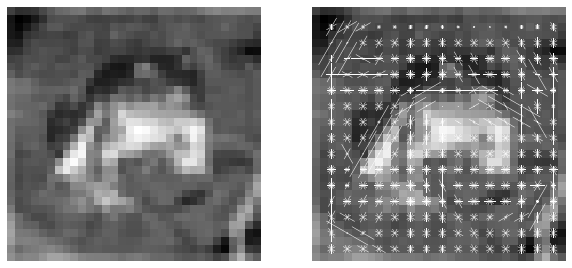

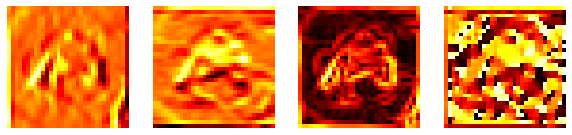

In [6]:
# Try running your code on a single image
img = X_train[0]
img = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
hog = extract_hog(img, cell_size=cell_size, block_size=block_size, plot=True)

In [22]:
# TODO: Build HOG representations
# Note: This may take some time to run
X_train_hog = []
for img in X_train[:200]:
    gray = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
    hog = extract_hog(gray, cell_size=cell_size, block_size=block_size)
    X_train_hog.append(hog)

X_train_hog = np.array(X_train_hog)

X_val_hog = []
for img in X_val[:200]:
    gray = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
    hog = extract_hog(gray, cell_size=cell_size, block_size=block_size)
    X_val_hog.append(hog)
    
X_val_hog = np.array(X_val_hog)
    
X_test_hog = []
for img in X_test[:200]:
    gray = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2GRAY)
    hog = extract_hog(gray, cell_size=cell_size, block_size=block_size)
    X_test_hog.append(hog)
    
X_test_hog = np.array(X_test_hog)

In [23]:
# TODO: Add bias dimension and transform into columns
X_train = np.hstack((X_train_hog, np.ones((X_train_hog.shape[0], 1))))
X_val = np.hstack((X_val_hog, np.ones((X_val_hog.shape[0], 1))))
X_test = np.hstack((X_test_hog, np.ones((X_test_hog.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (200, 5401)
Train labels shape:  (4500,)
Validation data shape:  (200, 5401)
Validation labels shape:  (500,)
Test data shape:  (200, 5401)
Test labels shape:  (1000,)


In [24]:
# TODO: Define regularization strengths
regularization_strengths = np.linspace(0, 10000, 25)

# Train a classifier
best_color = train(X_train, y_train[:200], X_val, y_val[:200], X_test, y_test[:200], regularization_strengths)

reg 0.000000e+00 train accuracy: 0.110000 val accuracy: 0.110000
reg 4.166667e+02 train accuracy: 0.145000 val accuracy: 0.120000
reg 8.333333e+02 train accuracy: 0.140000 val accuracy: 0.125000
reg 1.250000e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 1.666667e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 2.083333e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 2.500000e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 2.916667e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 3.333333e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 3.750000e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 4.166667e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 4.583333e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 5.000000e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 5.416667e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 5.833333e+03 train accuracy: 0.140000 val accuracy: 0.125000
reg 6.250000e+03 train ac

## Question 6. Pixels (5 points)

Finally, let's use the pixels themselves to train a classifier. That is, just reshape a 32x32x3 image into a 32x32x3=3072 vector.

**Do this:** Process the images and train a classifier.

In [25]:
# Freshly load the data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir='/Users/SamLiang/Documents/Princeton/Classes/Junior Semester 1/COS 429/A2/COS429_a2/cifar-10-batches-py',
                                                                  num_training=4500, 
                                                                  num_validation=500, 
                                                                  num_test=1000)

Train data shape:  (4500, 32, 32, 3)
Train labels shape:  (4500,)
Validation data shape:  (500, 32, 32, 3)
Validation labels shape:  (500,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [27]:
# TODO: Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], 32 * 32 * 3))
X_val = np.reshape(X_val, (X_val.shape[0], 32 * 32 * 3))
X_test = np.reshape(X_test, (X_test.shape[0], 32 * 32 * 3))
    
# TODO: Normalize the data by subtracting the mean training image from all images
mean_train_img = np.mean(X_train, axis=0)
X_train = X_train - mean_train_img
X_val = X_val - mean_train_img
X_test = X_test - mean_train_img
    
# TODO: Add bias dimension and transform into columns
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4500, 3073)
Train labels shape:  (4500,)
Validation data shape:  (500, 3073)
Validation labels shape:  (500,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


In [ ]:
# TODO: Define regularization strengths
regularization_strengths = np.linspace(0, 10000, 100)

# Train a classifier
best_color = train(X_train, y_train, X_val, y_val, X_test, y_test, regularization_strengths)

## Question 7. Results (10 points)

**Do this**: 

7-a. Create a table of the five models' achieved accuracy, best hyperparameter, and runtime. (6 points)

7-b. Briefly describe your results in a few sentences. Feel free to share your experience and highlight any interesting observations (e.g., you had to do more hyperparameter tuning for some than others). (4 points)

## Question 8. Analysis (10 points)

**Do this**: Create a confusion matrix for each of the five models. Feel free to use existing implementations such as [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) but make sure to interpret some subset of the results and demonstrate that you understand what the values in the confusion matrices mean. Do the confusion matrices reveal any interesting insights (e.g., truck is always misclassified as automobile)? For each of the 10 classes, which model works best? Describe any hypotheses you have on the results. One or two paragraphs would be sufficient.

## Question 9. Improvement (9 points)

**Do this**: Identify one shortcoming of one or few of the systems you've worked with. Name an improvement you can implement to improve the system(s). You don't have to actually implement your proposed improvement, but describe exactly how you could go about implementing it and what pitfalls you might anticipate. What would be the pros and cons of this intervention? One or two paragraphs would be sufficient.

## Question 10. What to Use (6 points)

So far we explored how different features work for 10-way image classification.

**Do this**: 

9-a. For the task of **object detection**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('objectdetection.jpeg')
plt.figure(figsize=(10, 10)); plt.title('Object detection')
plt.imshow(img); plt.axis('off'); plt.show()

9-b. For the task of **face detection**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('facedetection.png')
plt.figure(figsize=(10, 10)); plt.title('Face detection')
plt.imshow(img); plt.axis('off'); plt.show()

9-c. For the task of **scene classification**, which features do you think would work best? Describe your reasons in a few senteces. (2 points)

In [ ]:
img = cv2.imread('sceneclassification.jpeg')
plt.figure(figsize=(10, 10)); plt.title('Scene classification')
plt.imshow(img); plt.axis('off'); plt.show()